In [4]:
from brian2 import *
from DynapSE import DynapSE
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from Spike_G import SpikeGen

# Display plots inside Jupyter cell
%matplotlib inline
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings/dynapse-simulator-New-Parameters/

BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

In [92]:
freq_list=[200,300]*Hz
inp_duration=1

input_monitors=[]
PC_monitors=[]
SST_monitors=[]
PV_monitors=[]

for freq in freq_list:   
    # to start a new build to run multiple full simulations
    device.reinit()
    device.activate()
    # need to reset the defaultclock after activate
    defaultclock.dt = 20 * us

    # Create a Brian2 network and chip instance using that monitors Dynap-SE1 resources.
    network = Network()
    chip = DynapSE(network)

    # ///////////////////////////// Populations ////////////////////////////////////////////////
    # number neurons
    n = 10
    exc = round(n * 0.8)
    inh = round(n * 0.2)
    n_PC = exc 
    n_SST = round(inh * 0.42)
    n_PV = round(inh * 0.58)
    print("neurons:"+str(n_PC)+str(n_SST)+str(n_PV))

    # define the populations of neurons
    PC = chip.get_neurons(n_PC, 'Core_1')
    SST = chip.get_neurons(n_SST, 'Core_2')
    PV = chip.get_neurons(n_PV, 'Core_3')

    
    # ///////////////////////////// Freqiiecy Input to PC ////////////////////////////////////////////////
    spikegen = SpikeGen('regular',0,1,1,freq,1,'SpikeGenerator')

    # ///////////////////////////// CONNECTIONS ////////////////////////////////////////////////

    # Synapses, Thalamacortical Connections
    syn_inpPC = chip.add_connection(spikegen, PC, synapse_type='AMPA')
    chip.connect(syn_inpPC,True)
    syn_inpPV = chip.add_connection(spikegen, PV, synapse_type='AMPA')
    chip.connect(syn_inpPV,True)
    syn_inpSST = chip.add_connection(spikegen, SST, synapse_type='AMPA')
    chip.connect(syn_inpSST,True)

    # set Thalamacortical weights
    syn_inpPC.weight = 300
    syn_inpPV.weight = 200
    syn_inpSST.weight = 700

    # Synapses, Local Connections
    syn_PC = chip.add_connection(PC, PC, synapse_type='NMDA')
    syn_PC.connect(p=0.30)
    syn_PV = chip.add_connection(PV, PV, synapse_type='GABA_B')
    chip.connect(syn_PV,True)

    syn_SSTPC = chip.add_connection(SST, PC, synapse_type='GABA_B')
    syn_SSTPC.connect(p=0.8)
    syn_PVPC = chip.add_connection(PV, PC, synapse_type='GABA_B')
    syn_PVPC.connect(p=0.8)

    syn_PCSST = chip.add_connection(PV, SST, synapse_type='NMDA')
    chip.connect(syn_PCSST,True)
    syn_PCPV = chip.add_connection(PC, PV, synapse_type='NMDA')
    chip.connect(syn_PCPV,True)

    syn_PVSST = chip.add_connection(PV, SST, synapse_type='GABA_B')
    chip.connect(syn_PVSST,True)
    syn_SSTPV = chip.add_connection(SST, PV, synapse_type='GABA_B')
    chip.connect(syn_SSTPV,True)

    
    # set Local connection weights
    syn_PC.weight = 300
    syn_PV.weight = -300
    syn_SSTPC.weight = -600
    syn_PVPC.weight = -300
    syn_PCSST.weight = 300
    syn_PCPV.weight = 300
    syn_PVSST.weight = -300
    syn_SSTPV.weight = -300
    

    # apply conditions
    PV_conf = {"Itau": 50 * pA}
    SST_conf = {"Itauahp": 0.03 * pA,            
            "Ithahp": 0.06 * pA,
            "Ispkthr": 0.5 * nA # low threhsold spiking
           }
    PC_conf =  {
            "Itau" : 2 * pA,
            "Ith"  : 10 * pA,                   
            "Itauahp": 0.5 * pA,                 
            "Ithahp": .5 * pA,
            "Ica" : 6 * pA,
            "refP": 5. * ms}

    # set the params
    chip.set_bias(PV_conf, 'Core_3')
    chip.set_bias(SST_conf, 'Core_2')
    chip.set_bias(PC_conf, 'Core_1')



    # Monitors
    mon_neuron_input  = SpikeMonitor(spikegen, name='mon_neuron_input')
    SST_output = SpikeMonitor(SST, name='SST_output')
    PV_output = SpikeMonitor(PV, name='PV_output')
    PC_output = SpikeMonitor(PC, name='PC_output')

    network.add([spikegen,PC,SST,PV,syn_inpPC,syn_inpPV,syn_inpSST,syn_PC,syn_PV,syn_SSTPC,syn_PVPC,syn_PCSST,syn_PCPV,syn_PVSST,syn_SSTPV,SST_output,mon_neuron_input,PV_output,PC_output])
    
    # Simulation
    network.run(inp_duration * 1000 * ms)
    list=mon_neuron_input
    print(list)
    input_monitors.append(mon_neuron_input.t/ms)
    print(input_monitors[0])
    PC_monitors.append(SST_output)
    SST_monitors.append(PV_output)
    PV_monitors.append(PC_output)
    print(freq)
    print(spikegen)


   




neurons:811
8 neurons are allocated from Core_1.
1 neurons are allocated from Core_2.
1 neurons are allocated from Core_3.
New bias values are loaded to Core_3.
New bias values are loaded to Core_2.
New bias values are loaded to Core_1.
<SpikeMonitor, recording from 'mon_neuron_input'>
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545. 550. 555.
 560. 565. 570. 575. 580. 585. 590. 595. 600. 605. 610. 615. 620. 625.
 630. 635. 640. 645. 650. 655. 660. 665. 670. 675. 680. 685. 690. 695.
 70

In [94]:
input_monitors[1]

array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
        33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,
        66.,  69.,  72.,  75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,
        99., 102., 105., 108., 111., 114., 117., 120., 123., 126., 129.,
       132., 135., 138., 141., 144., 147., 150., 153., 156., 159., 162.,
       165., 168., 171., 174., 177., 180., 183., 186., 189., 192., 195.,
       198., 201., 204., 207., 210., 213., 216., 219., 222., 225., 228.,
       231., 234., 237., 240., 243., 246., 249., 252., 255., 258., 261.,
       264., 267., 270., 273., 276., 279., 282., 285., 288., 291., 294.,
       297., 300., 303., 306., 309., 312., 315., 318., 321., 324., 327.,
       330., 333., 336., 339., 342., 345., 348., 351., 354., 357., 360.,
       363., 366., 369., 372., 375., 378., 381., 384., 387., 390., 393.,
       396., 399., 402., 405., 408., 411., 414., 417., 420., 423., 426.,
       429., 432., 435., 438., 441., 444., 447., 45

0


KeyError: <DynamicArrayVariable(dimensions=second,  dtype=float64, scalar=False, constant=False, read_only=True)>

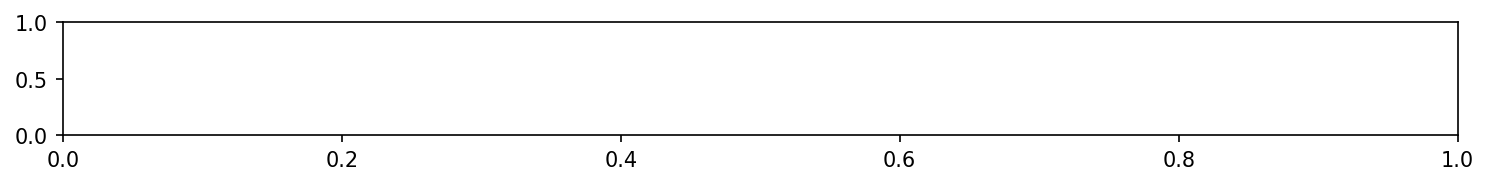

In [57]:
for i in range(len(freq_list)): 
    print(i)
    plt.figure(figsize=(12,10),dpi=150)
    plt.subplots_adjust(hs$
    
    pace=2)
    plt.subplot(411)       
    spike_placeholder = np.zeros(1000)
    spike_placeholder[np.array(input_monitors[i]/ms, dtype=int)]=1
    plt.plot(spike_placeholder,'k|')
    matplotlib.pyplot.yticks(range(1, 3))
    plt.ylim(0.5, 1.5)
    plt.title('Input Spikes')
    plt.ylabel('Neuron ID')


    matplotlib.pyplot.yticks(range(1,3))
    plt.subplot(412)
    plot(SST_monitors[i].t,SST_monitors[i].i,'k|')
    matplotlib.pyplot.yticks(range(1,3))
    plt.subplot(413)
    plot(PV_monitors[i].t,PV_monitors[i].i,'k|')
    matplotlib.pyplot.yticks(range(0,1))
    plt.subplot(414)
    plot(PC_monitors[i].t,PC_monitors[i],'k|')
    matplotlib.pyplot.yticks(range(1,9))

    plt.tight_layout()

    print('SST output firing rate= ', SST_monitors[i].count/ (inp_duration* 1000 * ms))
    print('PC output firing rate= ', PC_monitors[i].count/ (inp_duration* 1000 * ms))
    print('PV output firingimport ', PV_monitors[i].count/ (inp_duration* 1000 * ms))

In [82]:
x=input_monitors[1].get_spikes_of(0)
print(x)


AttributeError: 'VariableView' object has no attribute 'get_spikes_of'

In [28]:
print(freq)

300. Hz


In [12]:
def remove_last_element(arr):
    return arr[np.arange(arr.size - 1)]

neurons:811
8 neurons are allocated from Core_1.
1 neurons are allocated from Core_2.
1 neurons are allocated from Core_3.
New bias values are loaded to Core_3.
New bias values are loaded to Core_2.
New bias values are loaded to Core_1.
SST output firing rate=  [1.] Hz
PC output firing rate=  [ 57.  58.  59.  64.  58.  71. 162.  57.] Hz
PV output firingimport  [28.] Hz
neurons:811
8 neurons are allocated from Core_1.
1 neurons are allocated from Core_2.
1 neurons are allocated from Core_3.
New bias values are loaded to Core_3.
New bias values are loaded to Core_2.
New bias values are loaded to Core_1.
SST output firing rate=  [1.] Hz
PC output firing rate=  [180.  81.  83. 181.  76. 165.  64.  73.] Hz
PV output firingimport  [29.] Hz


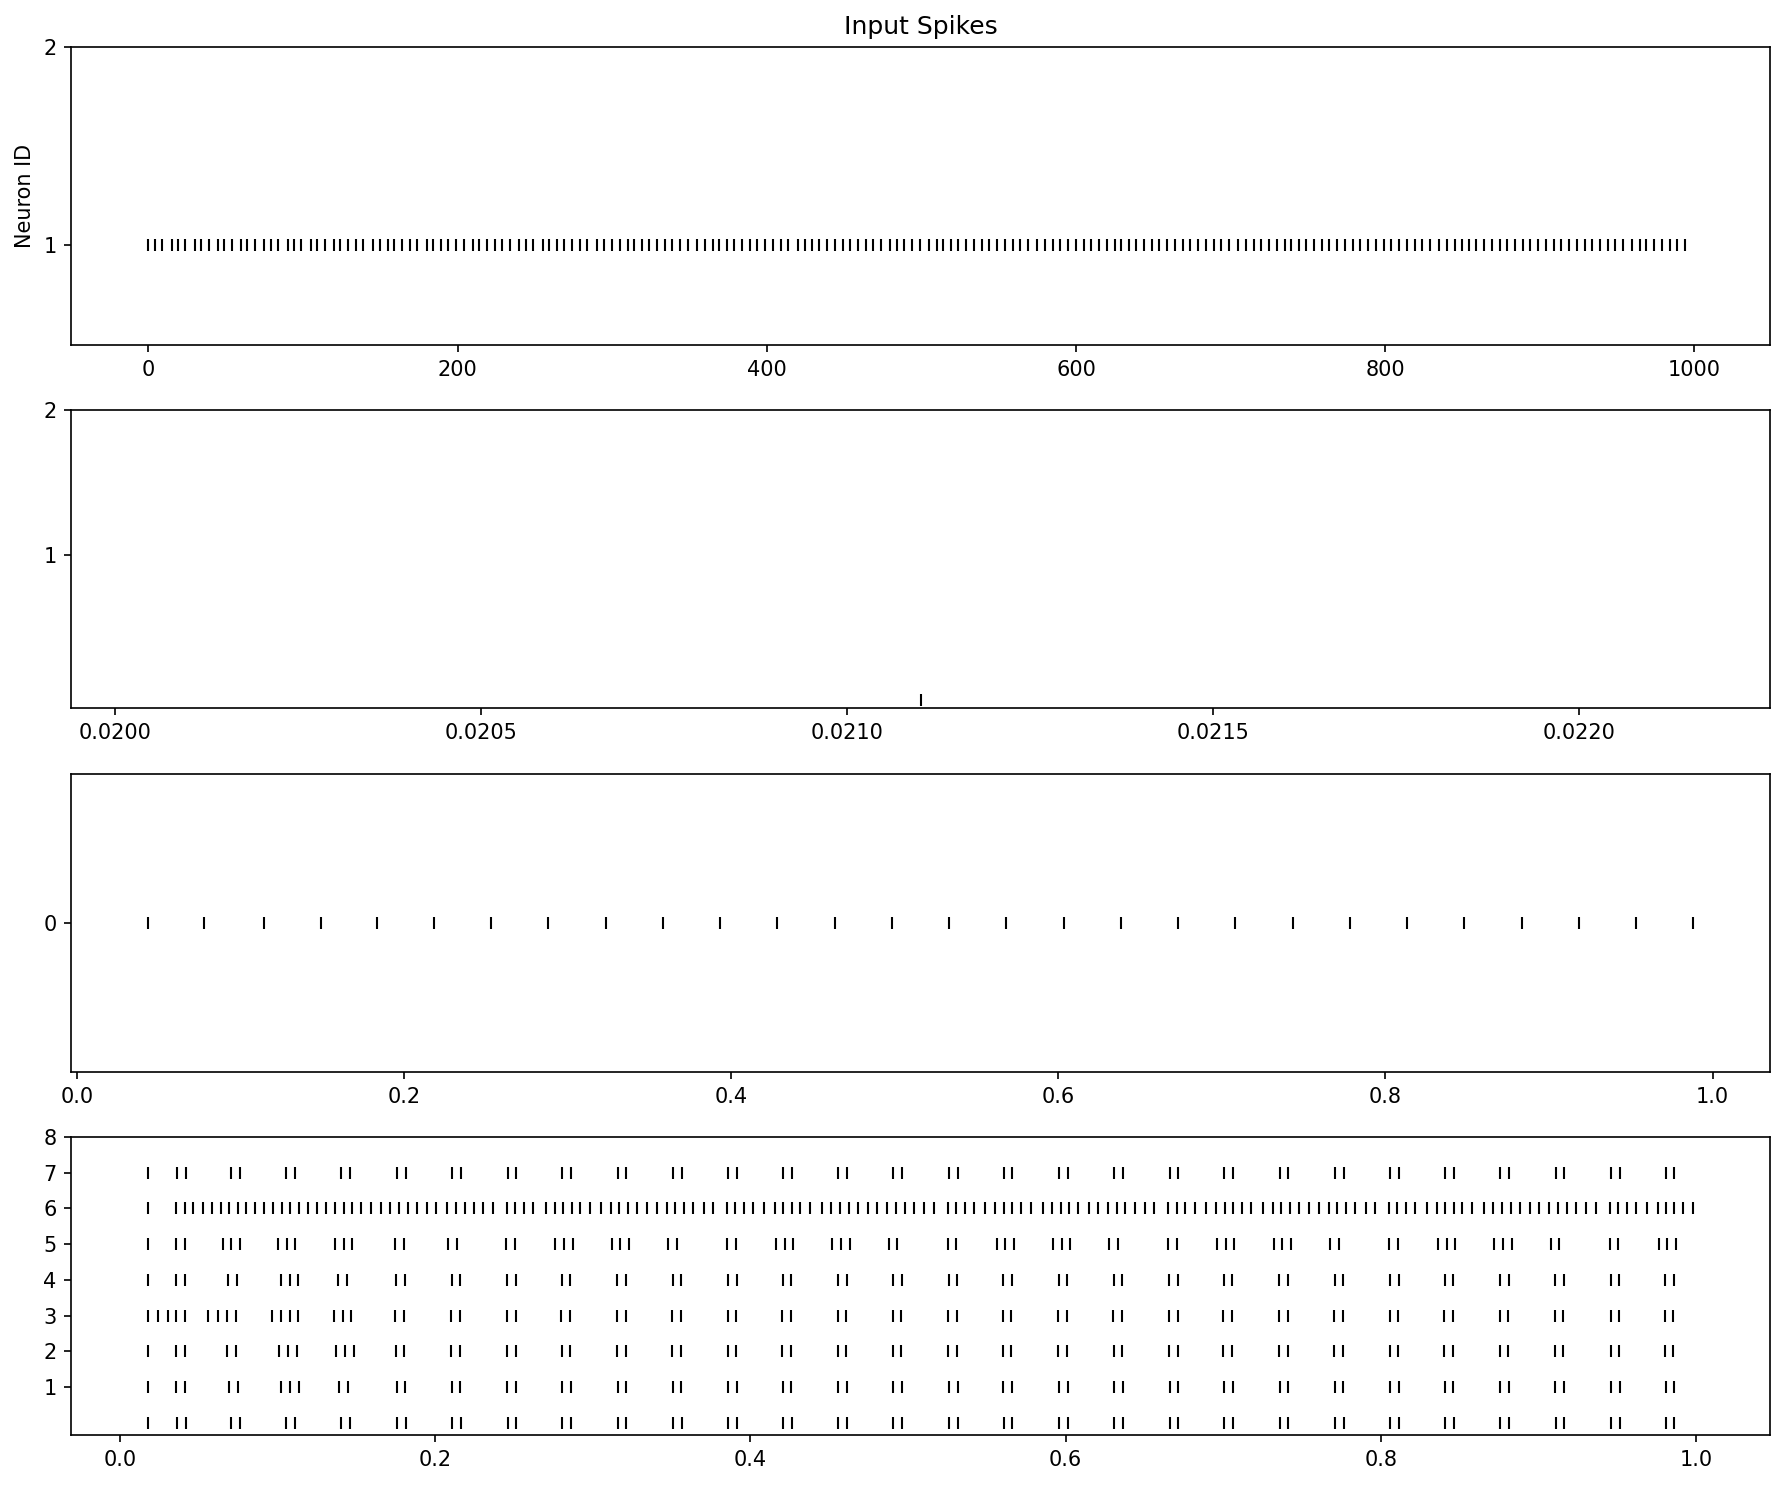

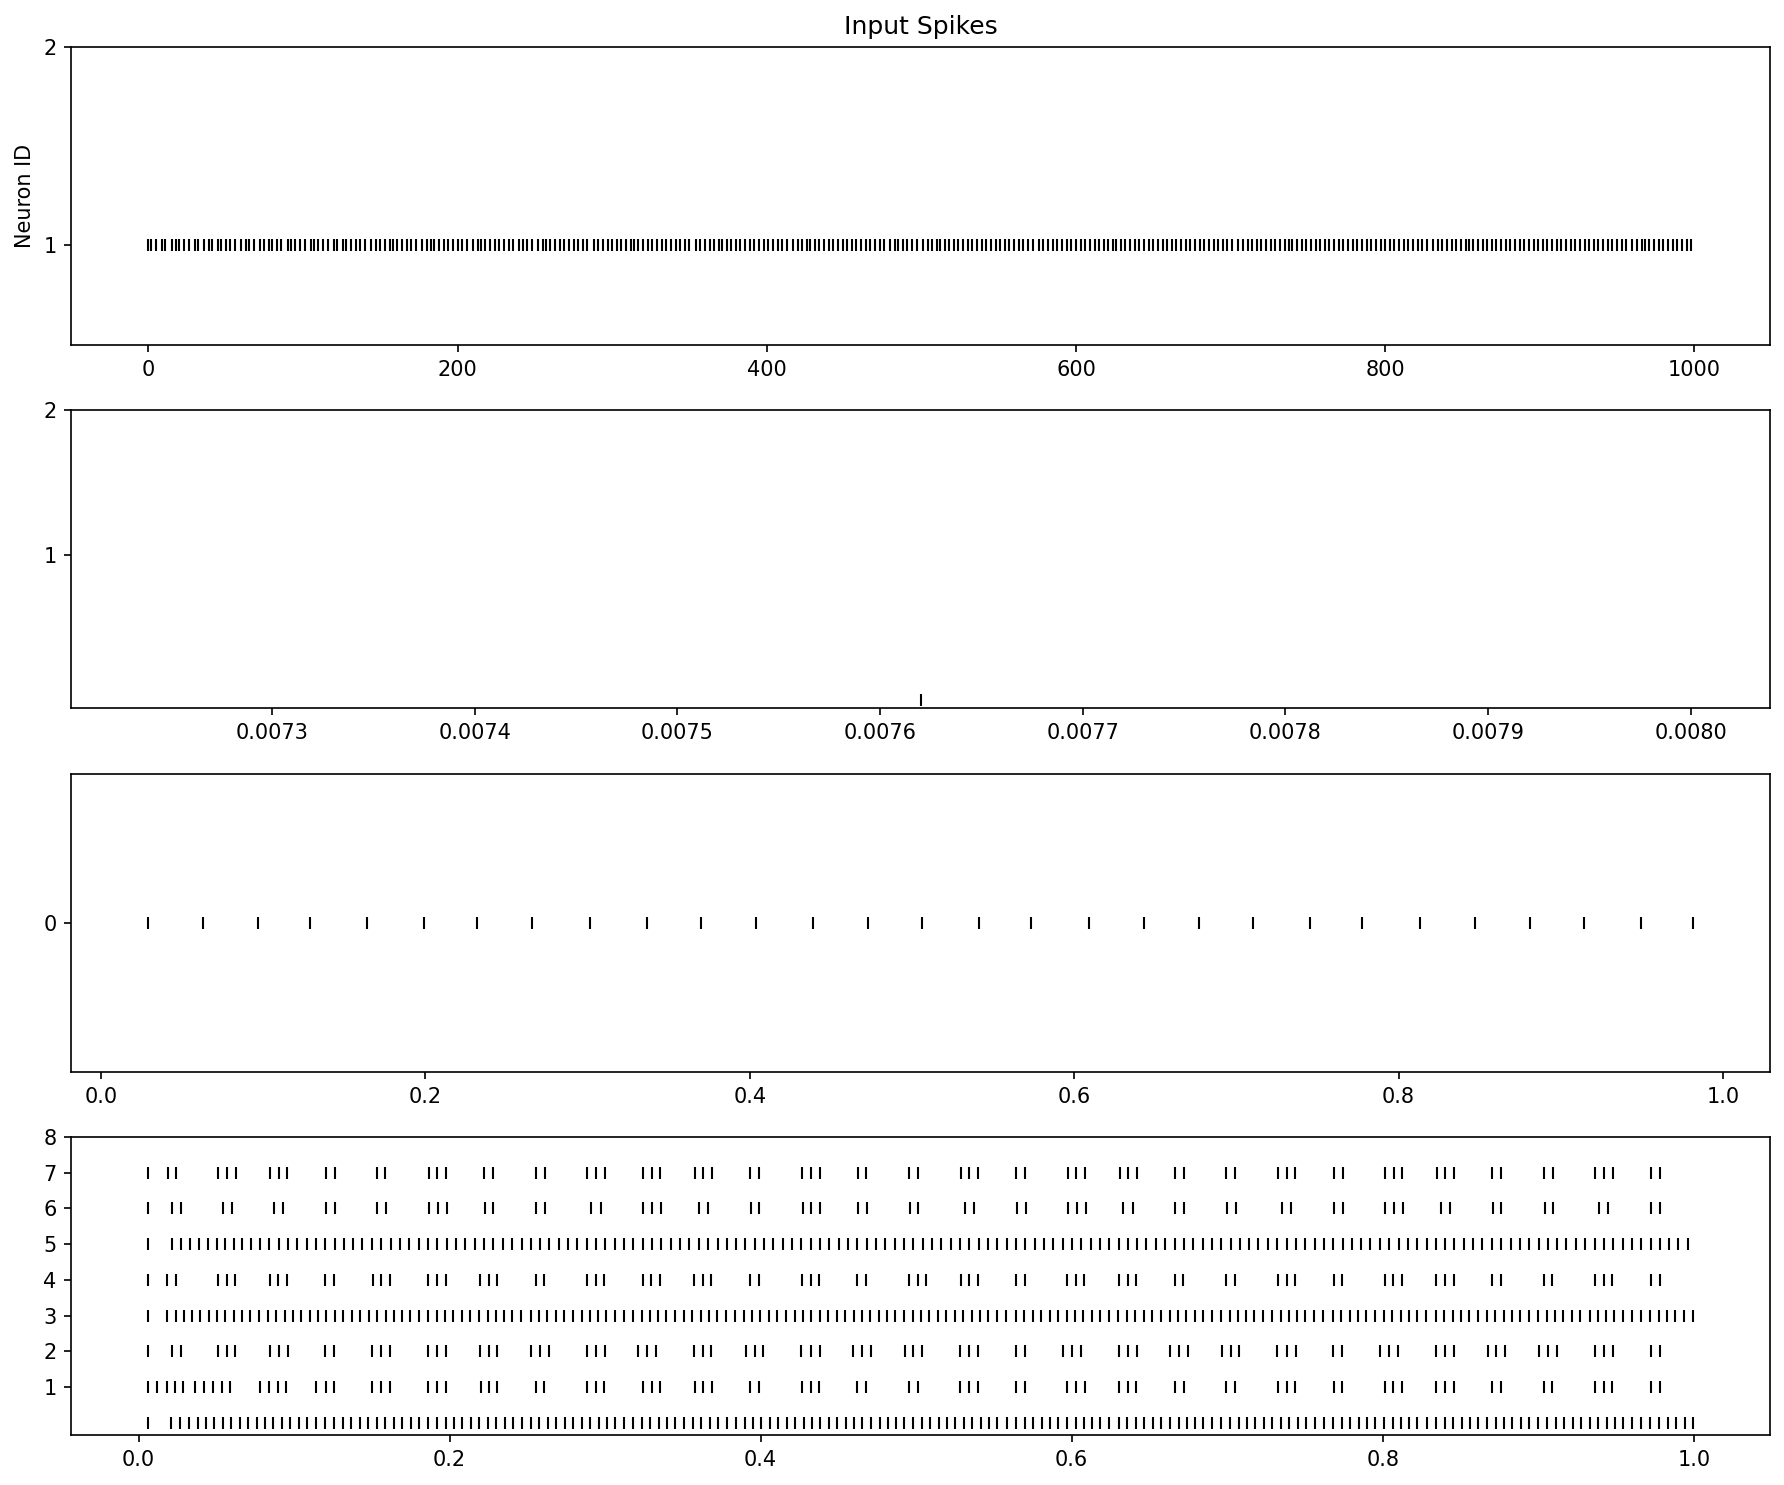